In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from datetime import datetime, timedelta
import networkx as nx
from networkx.algorithms import bipartite
from tqdm.notebook import tqdm
import imageio
import os

In [2]:
df = pd.read_csv('../data/rappler-business-with-ner-timestep-sentiment-score.csv')
df.head()

,Unnamed: 0,date,id,link,categories,authorship,tags,unique_entities,author.name,time_step,sentiment_score
0,0,2022-01-01 12:59:53,1542619,https://www.rappler.com/business/bohol-starts-...,"[621, 624, 701]",[2573],"[1263, 2814, 2290]","['Typhoon Odette', 'Arthur Yap']",NaN,0,0.055859
1,1,2022-01-01 19:54:55,1543036,https://www.rappler.com/business/turkey-lira-c...,"[621, 622]",[5083],"[2625, 1870, 1235]","['Marek Drimal', 'Nureddin Nebati', 'Tayyip Er...",NaN,0,0.007710
2,2,2022-01-01 20:29:57,1543064,https://www.rappler.com/business/indonesia-ban...,"[621, 622, 624]",[5083],"[2716, 1141, 2290]","['Ridwan Jamaludin', 'Perusahaan Listrik Negar...",NaN,0,-0.014912
3,3,2022-01-02 11:34:10,1543150,https://www.rappler.com/business/department-tr...,"[621, 628, 622]",[4270],"[3029, 2802]","['Ramon Lopez', 'Rodrigo Duterte', 'Typhoon Od...",Michelle Abad,0,-0.025336
4,4,2022-01-03 21:00:57,1544290,https://www.rappler.com/business/indonesia-min...,"[621, 624]",[5083],"[2716, 1141, 2648]","['Perusahaan Listrik Negara', 'Puneet Gupta', ...",NaN,0,0.004880


In [3]:
df.shape

(2871, 11)

In [4]:
print(df['date'].min())
print(df['date'].max())

2022-01-01 12:59:53
2023-07-22 11:20:47


In [5]:
(~df['author.name'].isna()).sum()

457

In [6]:
entities = []
for e in df['unique_entities']:
    entities += eval(e)
print('There are', df['id'].nunique(), 'unique news articles.')
print('There are', len(entities), 'mentions of unique entities.')
print('There are', len(np.unique(entities)), 'unique entities.')

There are 2871 unique news articles.
There are 12742 mentions of unique entities.
There are 6858 unique entities.


## Entities linked by Existence in Articles

In [7]:
df['unique_entities']

0                        ['Typhoon Odette', 'Arthur Yap']
1       ['Marek Drimal', 'Nureddin Nebati', 'Tayyip Er...
2       ['Ridwan Jamaludin', 'Perusahaan Listrik Negar...
3       ['Ramon Lopez', 'Rodrigo Duterte', 'Typhoon Od...
4       ['Perusahaan Listrik Negara', 'Puneet Gupta', ...
                              ...                        
2866    ['Josephine Gotianun Yap', 'Jaime Bautista', '...
2867       ['Ronald Jason J Ramos', 'The Zobel de Ayala']
2868    ['Dennis Uy', 'Enrique Razon', 'Dennis Uy', 'R...
2869    ['Tayyip Erdogan', 'Daleep Singh', 'Colin Grah...
2870                ['Edgar Galvante', 'Rodrigo Duterte']
Name: unique_entities, Length: 2871, dtype: object

In [8]:
# Create an empty graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(df['id'], article=1)  # Add article nodes
# All entities from the 'unique_entities' column
all_entities = [entity for sublist in df['unique_entities'] for entity in eval(sublist)]
B.add_nodes_from(set(all_entities), article=0)  # Add entity nodes

# Add edges between articles and entities
for index, row in tqdm(df.iterrows()):
    article_id = row['id']
    entities = eval(row['unique_entities'])
    for entity in entities:
        B.add_edge(article_id, entity)

0it [00:00, ?it/s]

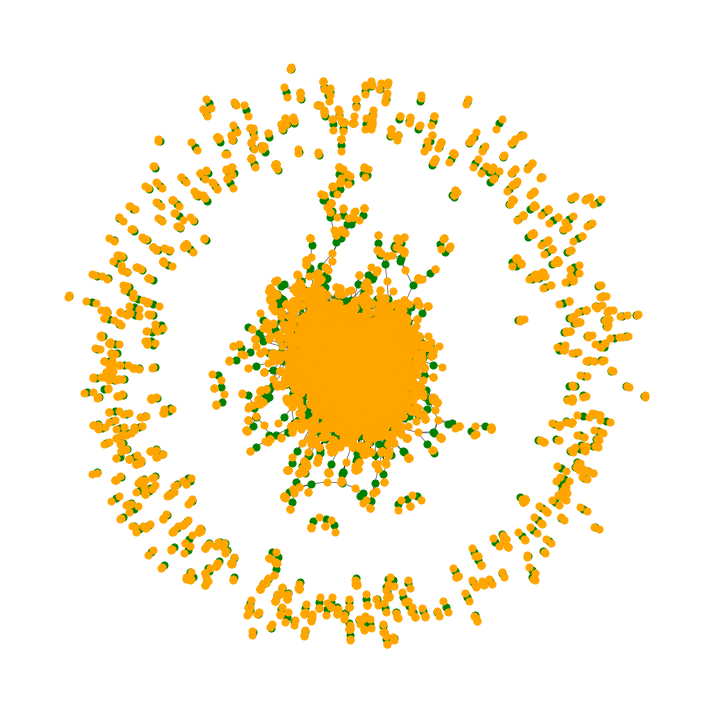

In [9]:
# Determine the nodes for each partition based on the 'bipartite' attribute
article_nodes = [n for n, d in B.nodes(data=True) if d['article']==1]
entity_nodes = [n for n, d in B.nodes(data=True) if d['article']==0]

# Create the bipartite layout
pos = nx.spring_layout(B, seed=34)

# Draw the graph
plt.figure(figsize=(10,10))

# Nodes
nx.draw_networkx_nodes(B, pos, nodelist=article_nodes, node_color='green', node_size=50)
nx.draw_networkx_nodes(B, pos, nodelist=entity_nodes, node_color='orange', node_size=50)

# Edges
nx.draw_networkx_edges(B, pos, width=1, alpha=0.5)  # added alpha for transparency

# If you want to show labels, uncomment the following line. Given the bipartite nature, it might clutter the visualization.
# nx.draw_networkx_labels(B, pos, font_size=12, font_family='sans-serif')

plt.axis('off')
plt.tight_layout()
plt.savefig('bipartite_graph.png', dpi=100)
plt.show()


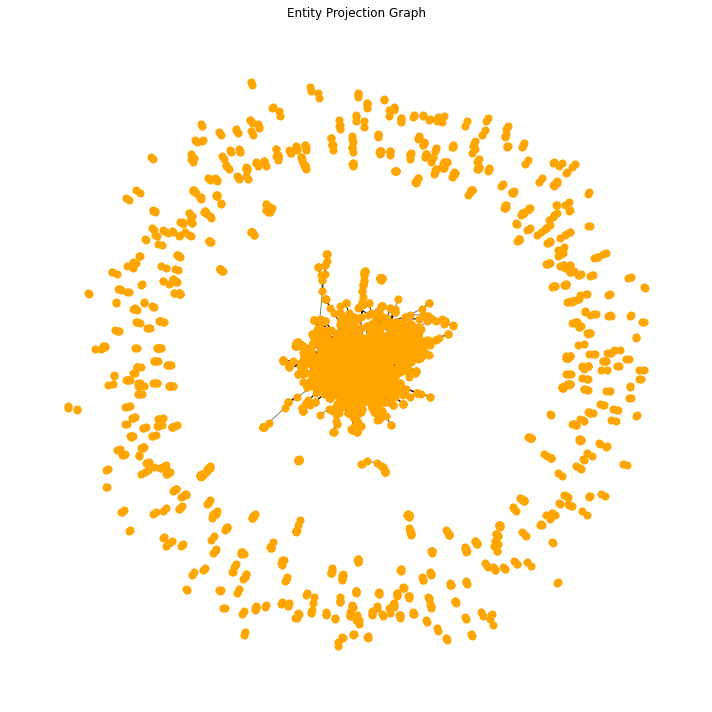

In [16]:
# 1. Create the entity projection
# Project the bipartite graph onto the entities nodes
entity_projection = nx.bipartite.weighted_projected_graph(B, entity_nodes)

# 2. Visualize the entity projection graph
# Use the spring layout for positioning
pos = nx.spring_layout(entity_projection, seed=34)

plt.figure(figsize=(10,10))

# Draw nodes and edges
nx.draw_networkx_nodes(entity_projection, pos, node_color='orange', node_size=50)
nx.draw_networkx_edges(entity_projection, pos, alpha=0.5)

# Labels can be added if desired, but with many nodes, it might be cluttered.
# If you want to show labels for specific important nodes or all nodes, you can uncomment the following line.
# nx.draw_networkx_labels(entity_projection, pos, font_size=10, font_family='sans-serif')

plt.title("Entity Projection Graph")
plt.axis('off')
plt.tight_layout()
plt.savefig('entity_projection_graph.png', dpi=100)
plt.show()

In [18]:
# Sort nodes by degree in descending order
sorted_degree = sorted(dict(entity_projection.degree()).items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their degrees
top_10_degree = sorted_degree[:10]

# Convert to a pandas DataFrame
df_top_10 = pd.DataFrame(top_10_degree, columns=['Node', 'Degree'])

df_top_10

,Node,Degree
0,Joe Biden,582
1,Ferdinand Marcos Jr,529
2,Vladimir Putin,474
3,Rodrigo Duterte,311
4,Jerome Powell,302
5,Janet Yellen,251
6,Liz Truss,206
7,Xi Jinping,194
8,Donald Trump,171
9,Benjamin Diokno,168


In [19]:
# Calculate weighted degree (strength) for each node
weighted_degree = dict(entity_projection.degree(weight='weight'))

# Sort nodes by weighted degree in descending order
sorted_weighted_degree = sorted(weighted_degree.items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their weighted degrees
top_10_weighted_degree = sorted_weighted_degree[:10]

# Convert to a pandas DataFrame
df_top_10_weighted = pd.DataFrame(top_10_weighted_degree, columns=['Node', 'Weighted Degree'])

df_top_10_weighted

,Node,Weighted Degree
0,Joe Biden,999
1,Ferdinand Marcos Jr,864
2,Vladimir Putin,764
3,Rodrigo Duterte,478
4,Jerome Powell,467
5,Janet Yellen,465
6,Liz Truss,330
7,Benjamin Diokno,265
8,Rishi Sunak,263
9,Donald Trump,246


In [20]:
# 2. Clustering Coefficient
clustering_coefficient = nx.clustering(entity_projection)
print(f"Average Clustering Coefficient: {nx.average_clustering(entity_projection)}")

# not interesting since all entities appearing in a single article will surely have 1

Average Clustering Coefficient: 0.813817278417306


In [21]:
clustering_coefficient_weighted = nx.clustering(entity_projection, weight='weight')
average_clustering_coefficient_weighted = sum(clustering_coefficient_weighted.values()) / len(entity_projection)
print(f"Average Weighted Clustering Coefficient: {average_clustering_coefficient_weighted}")

Average Weighted Clustering Coefficient: 0.016883838878198314


In [23]:
# Sort nodes by degree centrality in descending order
sorted_degree_centrality = sorted(nx.degree_centrality(entity_projection).items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their degree centralities
top_10_degree_centrality = sorted_degree_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_degree_centrality = pd.DataFrame(top_10_degree_centrality, columns=['Node', 'Degree Centrality'])

df_top_10_degree_centrality

,Node,Degree Centrality
0,Joe Biden,0.084877
1,Ferdinand Marcos Jr,0.077147
2,Vladimir Putin,0.069126
3,Rodrigo Duterte,0.045355
4,Jerome Powell,0.044043
5,Janet Yellen,0.036605
6,Liz Truss,0.030042
7,Xi Jinping,0.028292
8,Donald Trump,0.024938
9,Benjamin Diokno,0.024501


In [25]:
def weighted_degree_centrality(G, weight='weight'):
    # Calculate the weighted degree (strength) for each node
    strength = dict(G.degree(weight=weight))
    
    # Normalize by the maximum possible strength in the network (n-1 where n is the number of nodes)
    return {node: strength_val / (len(G) - 1) for node, strength_val in strength.items()}

# Calculate weighted degree centrality for each node
weighted_degree_cent = weighted_degree_centrality(entity_projection, weight='weight')

# Sort nodes by weighted degree centrality in descending order
sorted_weighted_degree_cent = sorted(weighted_degree_cent.items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their weighted degree centralities
top_10_weighted_degree_cent = sorted_weighted_degree_cent[:10]

# Convert to a pandas DataFrame
df_top_10_weighted_degree_centrality = pd.DataFrame(top_10_weighted_degree_cent, columns=['Node', 'Weighted Degree Centrality'])

df_top_10_weighted_degree_centrality

,Node,Weighted Degree Centrality
0,Joe Biden,0.145691
1,Ferdinand Marcos Jr,0.126003
2,Vladimir Putin,0.111419
3,Rodrigo Duterte,0.069710
4,Jerome Powell,0.068106
5,Janet Yellen,0.067814
6,Liz Truss,0.048126
7,Benjamin Diokno,0.038647
8,Rishi Sunak,0.038355
9,Donald Trump,0.035876


In [25]:
# Sort nodes by closeness centrality in descending order
sorted_closeness_centrality = sorted(
    nx.closeness_centrality(entity_projection).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their closeness centralities
top_10_closeness_centrality = sorted_closeness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_closeness = pd.DataFrame(top_10_closeness_centrality, columns=['Node', 'Closeness Centrality'])

df_top_10_closeness

,Node,Closeness Centrality
0,Joe Biden,0.331680
1,Vladimir Putin,0.296103
2,Donald Trump,0.294322
3,Xi Jinping,0.291003
4,Janet Yellen,0.285571
5,Kristalina Georgieva,0.279463
6,Jerome Powell,0.278704
7,Ferdinand Marcos Jr,0.276815
8,Rishi Sunak,0.275654
9,Ursula von der Leyen,0.273379


In [84]:
# Calculate the weighted closeness centrality for each node
# The distance parameter is set to the 'weight' attribute to account for edge weights
weighted_closeness_cent = nx.closeness_centrality(entity_projection, distance='weight')

# Sort nodes by weighted closeness centrality in descending order
sorted_weighted_closeness_cent = sorted(weighted_closeness_cent.items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their weighted closeness centralities
top_10_weighted_closeness_cent = sorted_weighted_closeness_cent[:10]

# Convert to a pandas DataFrame
df_top_10_weighted_closeness_centrality = pd.DataFrame(top_10_weighted_closeness_cent, columns=['Node', 'Weighted Closeness Centrality'])

df_top_10_weighted_closeness_centrality

,Node,Weighted Closeness Centrality
0,Joe Biden,0.290301
1,Donald Trump,0.260562
2,Rishi Sunak,0.255793
3,Ben van Beurden,0.253116
4,Ferdinand Marcos Jr,0.250493
5,Janet Yellen,0.249987
6,Liz Truss,0.249055
7,Rodrigo Duterte,0.247881
8,Jamie Dimon,0.247720
9,Xi Jinping,0.247109


In [26]:
# Sort nodes by betweenness centrality in descending order
sorted_betweenness_centrality = sorted(
    nx.betweenness_centrality(entity_projection).items(),
    key=lambda item: item[1],
    reverse=True)

# Get the top 10 nodes and their betweenness centralities
top_10_betweenness_centrality = sorted_betweenness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_betweenness = pd.DataFrame(top_10_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

df_top_10_betweenness

,Node,Betweenness Centrality
0,Joe Biden,0.226469
1,Ferdinand Marcos Jr,0.129743
2,Vladimir Putin,0.098049
3,Xi Jinping,0.063792
4,Donald Trump,0.058784
5,Rodrigo Duterte,0.057871
6,Jerome Powell,0.050466
7,Janet Yellen,0.037458
8,Rishi Sunak,0.024459
9,Elon Musk,0.022282


In [27]:
# 6. Density
density = nx.density(entity_projection)
print(f"Density: {density}")

Density: 0.0013365144290608125


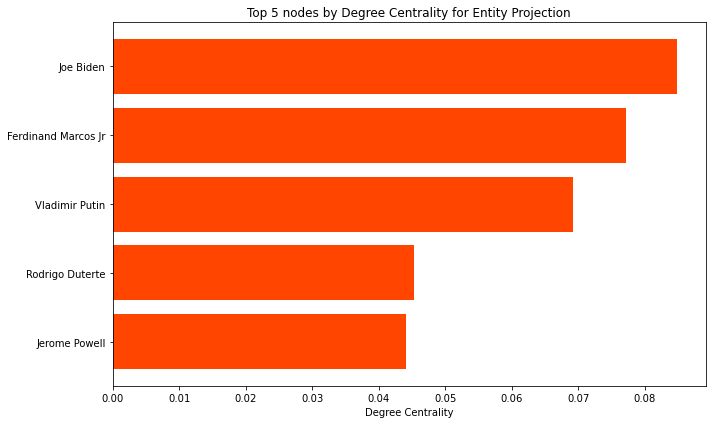

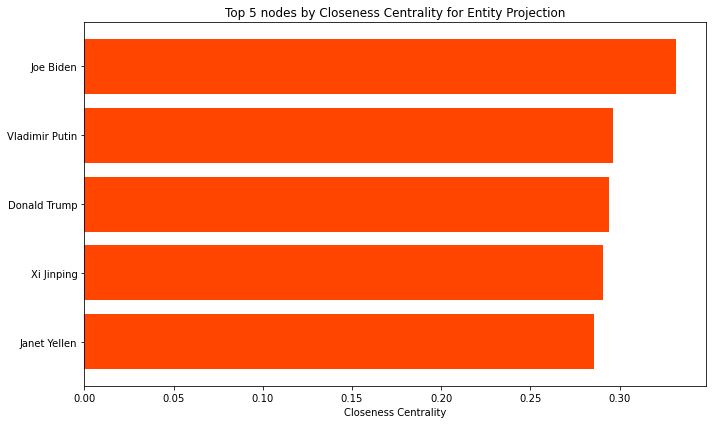

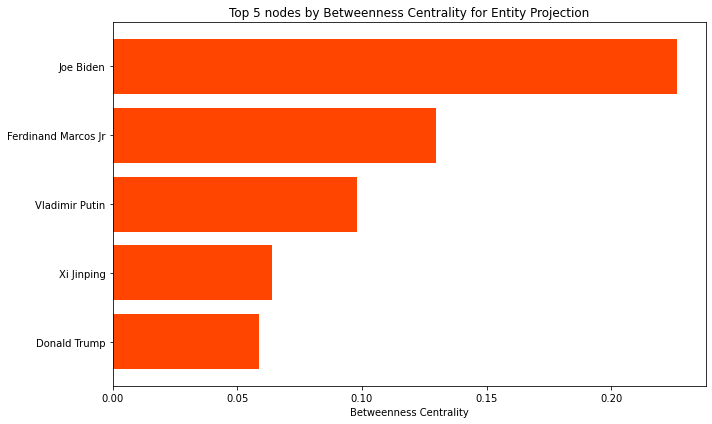

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

def plot_top_centrality(df, centrality_label, graph_title):
    """
    Function to plot top centrality measures in a horizontal bar chart
    """
    nodes = df['Node'].tolist()
    centrality_values = df[centrality_label].tolist()
    
    plt.figure(figsize=(10, 6))
    plt.barh(nodes, centrality_values, color='orangered')
    plt.xlabel(centrality_label)
    plt.title(f"Top 5 nodes by {centrality_label} for {graph_title}")
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest value at the top
    plt.tight_layout()
    plt.savefig(f"{centrality_label} for {graph_title}.png")
    plt.show()

# Assuming `entity_projection` is your graph of interest
graph_title = "Entity Projection"  # Replace with a suitable title

# Degree Centrality
sorted_degree_centrality = sorted(nx.degree_centrality(entity_projection).items(), key=lambda item: item[1], reverse=True)
df_top_5_degree_centrality = pd.DataFrame(sorted_degree_centrality[:5], columns=['Node', 'Degree Centrality'])
plot_top_centrality(df_top_5_degree_centrality, 'Degree Centrality', graph_title)

# Closeness Centrality
sorted_closeness_centrality = sorted(nx.closeness_centrality(entity_projection).items(), key=lambda item: item[1], reverse=True)
df_top_5_closeness = pd.DataFrame(sorted_closeness_centrality[:5], columns=['Node', 'Closeness Centrality'])
plot_top_centrality(df_top_5_closeness, 'Closeness Centrality', graph_title)

# Betweenness Centrality
sorted_betweenness_centrality = sorted(nx.betweenness_centrality(entity_projection).items(), key=lambda item: item[1], reverse=True)
df_top_5_betweenness = pd.DataFrame(sorted_betweenness_centrality[:5], columns=['Node', 'Betweenness Centrality'])
plot_top_centrality(df_top_5_betweenness, 'Betweenness Centrality', graph_title)


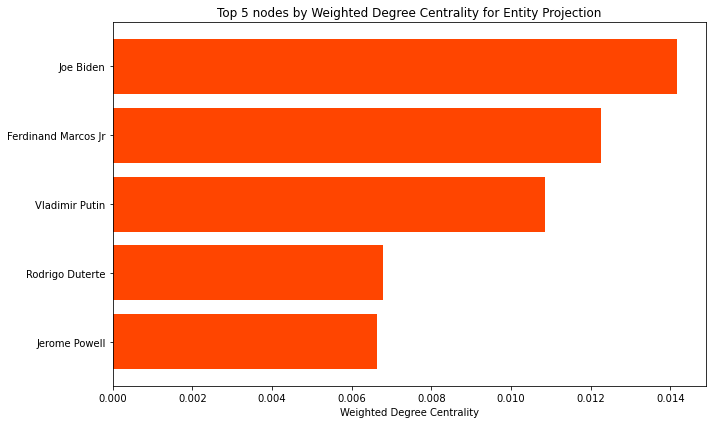

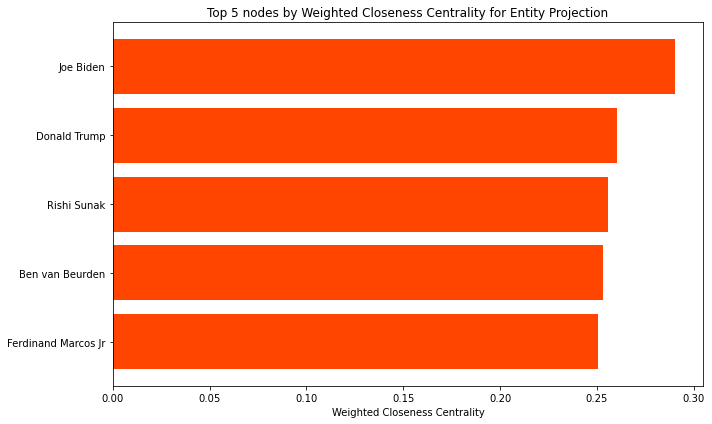

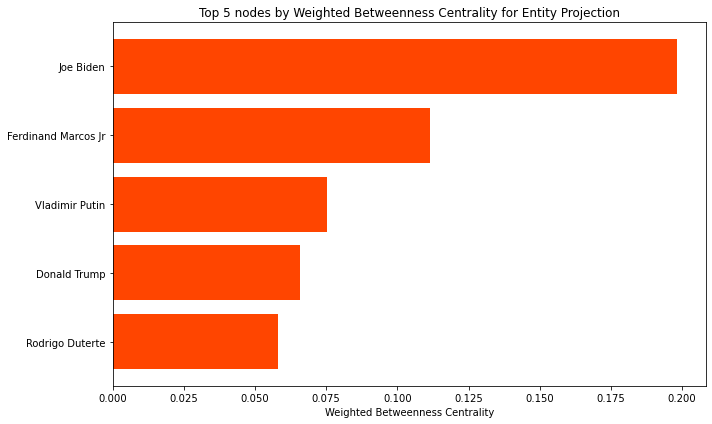

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

def plot_top_centrality(df, centrality_label, graph_title):
    """
    Function to plot top centrality measures in a horizontal bar chart
    """
    nodes = df['Node'].tolist()
    centrality_values = df[centrality_label].tolist()
    
    plt.figure(figsize=(10, 6))
    plt.barh(nodes, centrality_values, color='orangered')
    plt.xlabel(centrality_label)
    plt.title(f"Top 5 nodes by {centrality_label} for {graph_title}")
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest value at the top
    plt.tight_layout()
    plt.savefig(f"{centrality_label} for {graph_title}.png")
    plt.show()

# Assuming `entity_projection` is your graph of interest
graph_title = "Entity Projection"  # Replace with a suitable title

# Weighted Degree Centrality
total_weights = sum(dict(entity_projection.degree(weight='weight')).values())
weighted_degree_centrality = {node: deg/total_weights for node, deg in dict(entity_projection.degree(weight='weight')).items()}
sorted_degree_centrality = sorted(weighted_degree_centrality.items(), key=lambda item: item[1], reverse=True)
df_top_5_degree_centrality = pd.DataFrame(sorted_degree_centrality[:5], columns=['Node', 'Weighted Degree Centrality'])
plot_top_centrality(df_top_5_degree_centrality, 'Weighted Degree Centrality', graph_title)

# Weighted Closeness Centrality
sorted_closeness_centrality = sorted(nx.closeness_centrality(entity_projection, distance='weight').items(), key=lambda item: item[1], reverse=True)
df_top_5_closeness = pd.DataFrame(sorted_closeness_centrality[:5], columns=['Node', 'Weighted Closeness Centrality'])
plot_top_centrality(df_top_5_closeness, 'Weighted Closeness Centrality', graph_title)

# Weighted Betweenness Centrality
sorted_betweenness_centrality = sorted(nx.betweenness_centrality(entity_projection, weight='weight').items(), key=lambda item: item[1], reverse=True)
df_top_5_betweenness = pd.DataFrame(sorted_betweenness_centrality[:5], columns=['Node', 'Weighted Betweenness Centrality'])
plot_top_centrality(df_top_5_betweenness, 'Weighted Betweenness Centrality', graph_title)


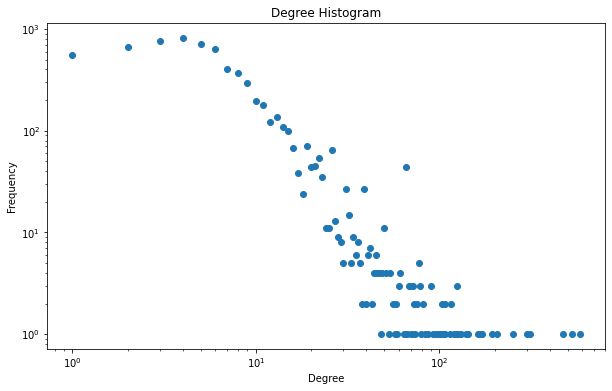

Average Clustering Coefficient: 0.8138172784173061
The entity_projection graph is not connected. Cannot compute average shortest path length.
Density: 0.0013365144290608125
Average Degree Centrality: 0.0013365144290608492
Average Closeness Centrality: 0.1506887179057598
Average Betweenness Centrality: 0.0002849247317061427
Average Eigenvector Centrality: 0.001777728370563071


In [33]:
# 1. Degree Distribution
degree_sequence = sorted([d for n, d in entity_projection.degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(10, 6))
plt.loglog(deg, cnt, 'o')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# 2. Clustering Coefficient
avg_clustering = nx.average_clustering(entity_projection)
print(f"Average Clustering Coefficient: {avg_clustering}")

# 3. Average Shortest Path Length (this can be computationally intensive for large networks)
# First, check if the graph is connected
if nx.is_connected(entity_projection):
    avg_path_length = nx.average_shortest_path_length(entity_projection)
    print(f"Average Shortest Path Length: {avg_path_length}")
else:
    print("The entity_projection graph is not connected. Cannot compute average shortest path length.")
    
# 4. Density
density = nx.density(entity_projection)
print(f"Density: {density}")

# 5. Degree Centrality
degree_centrality = nx.degree_centrality(entity_projection)
avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
print(f"Average Degree Centrality: {avg_degree_centrality}")

# 6.Closeness Centrality
closeness_centrality = nx.closeness_centrality(entity_projection)
avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
print(f"Average Closeness Centrality: {avg_closeness_centrality}")

# 7. Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(entity_projection)
avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
print(f"Average Betweenness Centrality: {avg_betweenness_centrality}")

# 8. Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(entity_projection, max_iter=1000)
avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
print(f"Average Eigenvector Centrality: {avg_eigenvector_centrality}")


## Articles linked by Similar Entities

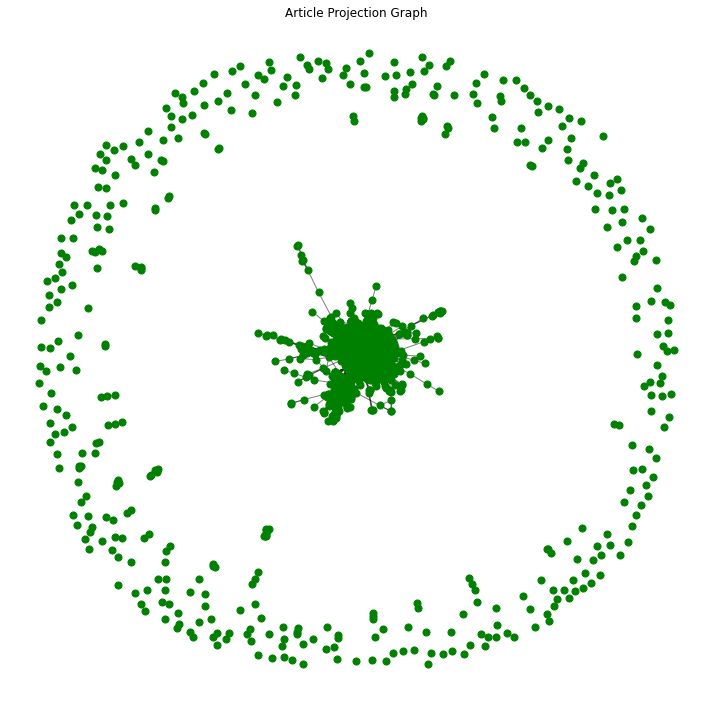

In [80]:
# 1. Create the article projection
# Project the bipartite graph onto the article nodes
article_projection = nx.bipartite.weighted_projected_graph(B, article_nodes)

# 2. Visualize the article projection graph
# Use the spring layout for positioning
pos = nx.spring_layout(article_projection, seed=34)

plt.figure(figsize=(10,10))

# Draw nodes and edges
nx.draw_networkx_nodes(article_projection, pos, node_color='green', node_size=50)
nx.draw_networkx_edges(article_projection, pos, alpha=0.5)

# Labels can be added if desired, but with many nodes, it might be cluttered.
# If you want to show labels for specific important nodes or all nodes, you can uncomment the following line.
# nx.draw_networkx_labels(article_projection, pos, font_size=10, font_family='sans-serif')

plt.title("Article Projection Graph")
plt.axis('off')
plt.tight_layout()
plt.savefig('article_projection_graph.png', dpi=100)
plt.show()

In [15]:
df['article_title'] = df['link'].str.split('/').apply(lambda x: x[-2])

In [16]:
# Sort nodes by degree in descending order
sorted_degree = sorted(
    dict(article_projection.degree()).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their degrees
top_10_degree = sorted_degree[:10]

# Convert to a pandas DataFrame
df_top_10 = pd.DataFrame(top_10_degree,
                         columns=['Node', 'Degree'])

df_top_10['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10.Node
].tolist()

df_top_10

,Node,Degree,titles
0,1750778,594,united-states-federal-reserve-white-house-slow...
1,1563360,545,updates-global-stock-markets-oil-prices-januar...
2,1646105,524,united-states-sanctions-russia-sberbank-putin-...
3,2276457,510,artificial-intelligence-race-canva-draws-line-...
4,1596589,482,momentum-grows-ban-russia-swift-payment-system...
5,1631758,469,china-sinopec-pauses-russia-projects-wary-sanc...
6,1631719,468,united-states-european-union-liquefied-natural...
7,1600144,466,china-boosts-oil-reserves-ignoring-united-stat...
8,2123714,466,russia-says-nord-stream-likely-hit-state-backe...
9,1597716,465,united-states-allies-target-russia-swift-ban-c...


In [17]:
# 2. Clustering Coefficient
clustering_coefficient = nx.clustering(article_projection)
print(f"Average Clustering Coefficient: {nx.average_clustering(article_projection)}")

# not interesting since all entities appearing in a single article will surely have 1

Average Clustering Coefficient: 0.6367534381915688


In [18]:
# Sort nodes by degree centrality in descending order
sorted_degree_centrality = sorted(
    nx.degree_centrality(article_projection).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their degree centralities
top_10_degree_centrality = sorted_degree_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_degree_centrality = pd.DataFrame(top_10_degree_centrality, columns=['Node', 'Degree Centrality'])

df_top_10_degree_centrality['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10_degree_centrality.Node
].tolist()

df_top_10_degree_centrality

,Node,Degree Centrality,titles
0,1750778,0.206969,united-states-federal-reserve-white-house-slow...
1,1563360,0.189895,updates-global-stock-markets-oil-prices-januar...
2,1646105,0.182578,united-states-sanctions-russia-sberbank-putin-...
3,2276457,0.177700,artificial-intelligence-race-canva-draws-line-...
4,1596589,0.167944,momentum-grows-ban-russia-swift-payment-system...
5,1631758,0.163415,china-sinopec-pauses-russia-projects-wary-sanc...
6,1631719,0.163066,united-states-european-union-liquefied-natural...
7,1600144,0.162369,china-boosts-oil-reserves-ignoring-united-stat...
8,2123714,0.162369,russia-says-nord-stream-likely-hit-state-backe...
9,1597716,0.162021,united-states-allies-target-russia-swift-ban-c...


In [19]:
# Sort nodes by closeness centrality in descending order
sorted_closeness_centrality = sorted(
    nx.closeness_centrality(article_projection).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their closeness centralities
top_10_closeness_centrality = sorted_closeness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_closeness = pd.DataFrame(top_10_closeness_centrality, columns=['Node', 'Closeness Centrality'])

df_top_10_closeness['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10_closeness.Node
].tolist()

df_top_10_closeness

,Node,Closeness Centrality,titles
0,2276457,0.405815,artificial-intelligence-race-canva-draws-line-...
1,1750778,0.405179,united-states-federal-reserve-white-house-slow...
2,1563360,0.399002,updates-global-stock-markets-oil-prices-januar...
3,1646105,0.397851,united-states-sanctions-russia-sberbank-putin-...
4,1597716,0.393459,united-states-allies-target-russia-swift-ban-c...
5,1596589,0.393235,momentum-grows-ban-russia-swift-payment-system...
6,1631758,0.392191,china-sinopec-pauses-russia-projects-wary-sanc...
7,1600144,0.391745,china-boosts-oil-reserves-ignoring-united-stat...
8,1861260,0.391522,saudi-arabia-walks-oil-policy-tightrope-betwee...
9,1631719,0.391374,united-states-european-union-liquefied-natural...


In [20]:
# Sort nodes by betweenness centrality in descending order
sorted_betweenness_centrality = sorted(
    nx.betweenness_centrality(article_projection).items(),
    key=lambda item: item[1],
    reverse=True)

# Get the top 10 nodes and their betweenness centralities
top_10_betweenness_centrality = sorted_betweenness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_betweenness = pd.DataFrame(top_10_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

df_top_10_betweenness['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10_betweenness.Node
].tolist()

df_top_10_betweenness

,Node,Betweenness Centrality,titles
0,2276457,0.169926,artificial-intelligence-race-canva-draws-line-...
1,2226280,0.017709,air-india-seals-record-order-airbus-boeing-jet...
2,1583387,0.016550,unilever-expects-new-ben-jerrys-arrangement-is...
3,1822661,0.016293,build-build-build-mapping-duterte-administrati...
4,2195285,0.016105,is-it-time-philippines-air-traffic-control-be-...
5,2134804,0.010633,international-monetary-fund-message-britain-of...
6,1647197,0.010304,easy-russia-sanctions-exhausted-united-states-...
7,2202488,0.009954,explainer-davos-2023-world-economic-forum
8,2136703,0.009875,britain-chancellor-exchequer-jeremy-hunt-vows-...
9,2291023,0.008828,united-states-california-regulators-seize-firs...


In [21]:
# 6. Density
density = nx.density(article_projection)
print(f"Density: {density}")

Density: 0.025947568924860765


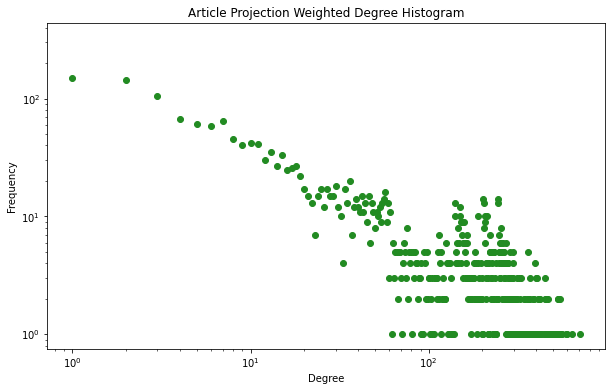

Weighted Average Clustering Coefficient: 0.05565409461143559
The article_projection graph is not connected. Cannot compute average shortest path length.
Density: 0.025947568924860765
Weighted Average Degree Centrality: 0.02594756892486076
Weighted Average Closeness Centrality: 0.23032488689070446
Weighted Average Betweenness Centrality: 0.0005623857450355932
Average Eigenvector Centrality: 0.007960050163795553


In [83]:
import collections
import matplotlib.pyplot as plt
import networkx as nx

# Assuming the article_projection is already defined elsewhere in your code
# For demonstration, I'm simply renaming entity_projection to article_projection

# 1. Weighted Degree Distribution
degree_sequence = sorted([d for n, d in article_projection.degree(weight='weight')], reverse=True)
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(10, 6))
plt.loglog(deg, cnt, 'o', color='forestgreen')  # Set color to forest green
plt.title("Article Projection Weighted Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.savefig("weighted_article_degree_histogram.png", dpi=200)

plt.show()

# 2. Clustering Coefficient (weighted)
avg_clustering = nx.average_clustering(article_projection, weight='weight')
print(f"Weighted Average Clustering Coefficient: {avg_clustering}")

# 3. Average Shortest Path Length (weighted)
if nx.is_connected(article_projection):
    avg_path_length = nx.average_shortest_path_length(article_projection, weight='weight')
    print(f"Weighted Average Shortest Path Length: {avg_path_length}")
else:
    print("The article_projection graph is not connected. Cannot compute average shortest path length.")
    
# 4. Density
density = nx.density(article_projection)
print(f"Density: {density}")

# 5. Weighted Degree Centrality
degree_centrality = nx.degree_centrality(article_projection)
avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
print(f"Weighted Average Degree Centrality: {avg_degree_centrality}")

# 6. Closeness Centrality (weighted)
closeness_centrality = nx.closeness_centrality(article_projection, distance='weight')  # Note the distance parameter
avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
print(f"Weighted Average Closeness Centrality: {avg_closeness_centrality}")

# 7. Betweenness Centrality (weighted)
betweenness_centrality = nx.betweenness_centrality(article_projection, weight='weight')
avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
print(f"Weighted Average Betweenness Centrality: {avg_betweenness_centrality}")

# 8. Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(article_projection, max_iter=1000)
avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
print(f"Average Eigenvector Centrality: {avg_eigenvector_centrality}")

## Temporal Analysis

In [7]:
def rolling_window_analysis(df, p):
    # Convert the 'date' column to datetime if it's not
    df['date'] = pd.to_datetime(df['date'])
    
    start_date = df['date'].min()
    end_date = df['date'].max()
    current_date = start_date
    
    results = {}
    
    while current_date <= end_date:
        # Filter dataframe for the current week
        week_df = df[(df['date'] >= current_date) & (df['date'] < current_date + timedelta(7))]
        
        # Create the bipartite graph
        B = nx.Graph()
        B.add_nodes_from(week_df['id'], bipartite=0)
        entities = [entity for sublist in week_df['unique_entities'] for entity in eval(sublist)]
        B.add_nodes_from(set(entities), bipartite=1)
        for _, row in week_df.iterrows():
            for entity in eval(row['unique_entities']):
                B.add_edge(row['id'], entity)
        
        # Project the bipartite graph
        entity_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
        entity_projection = nx.bipartite.projected_graph(B, entity_nodes)
        
        # Calculate the degree
        degree_dict = dict(entity_projection.degree())
        for entity, degree in degree_dict.items():
            if entity not in results:
                results[entity] = []
            results[entity].append((current_date, degree))
        
        # Move to the next day
        current_date += timedelta(1)

    # Fill in missing dates with 0
    all_dates = pd.date_range(start_date, end_date)
    for entity in results:
        existing_dates = {date for date, _ in results[entity]}
        missing_dates = set(all_dates) - existing_dates
        for missing_date in missing_dates:
            results[entity].append((missing_date, 0))
        results[entity].sort()  # sort by date after filling missing values

    # Sort entities by their maximum degree achieved in any week
    max_degree_entities = sorted(results, key=lambda x: max([degree for _, degree in results[x]]), reverse=True)
    
    # Consider only the top p entities
    top_p_entities = max_degree_entities[:p]
    
    # Plotting
    plt.figure(figsize=(15, 10))
    for entity in top_p_entities:
        values = results[entity]
        dates, degrees = zip(*values)
        plt.plot(dates, degrees, '-', label=entity)
    
    plt.ylabel("Degree")
    plt.xlabel("Date")
    plt.title(f"Top {p} entities' degree progression over time")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.tight_layout()
    plt.show()


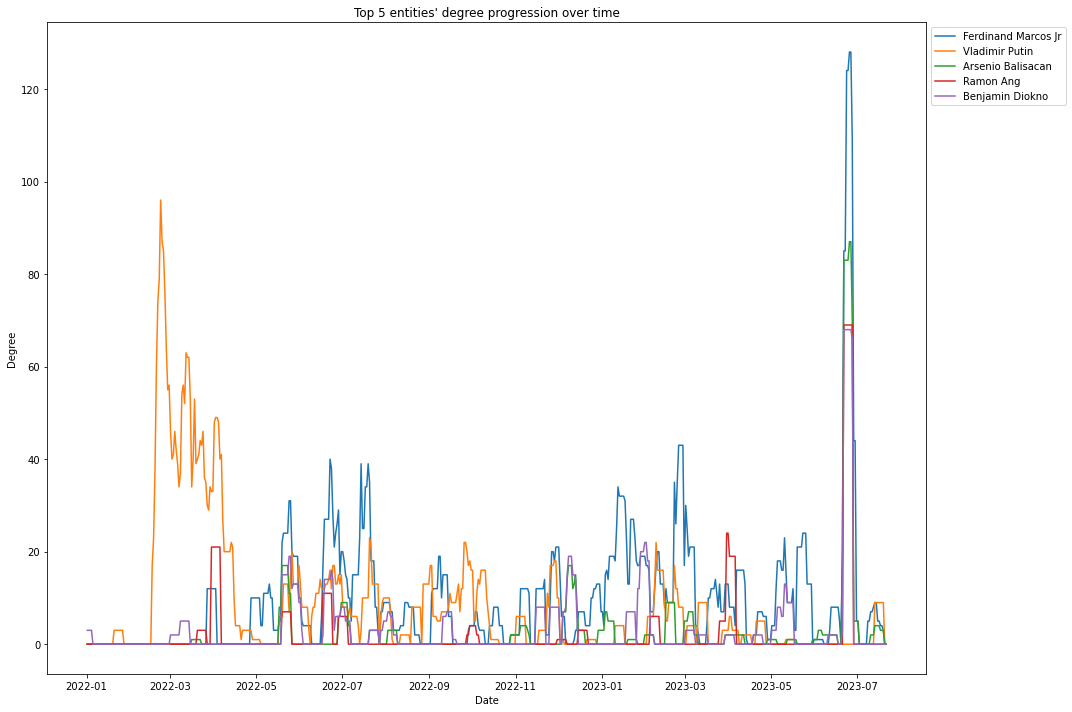

In [8]:
# Usage
rolling_window_analysis(df, 5)

In [26]:
def weighted_rolling_window_analysis(df, p):
    # Convert the 'date' column to datetime if it's not
    df['date'] = pd.to_datetime(df['date'])
    
    start_date = df['date'].min()
    end_date = df['date'].max()
    current_date = start_date
    
    results = {}
    
    while current_date <= end_date:
        # Filter dataframe for the current week
        week_df = df[(df['date'] >= current_date) & (df['date'] < current_date + timedelta(7))]
        
        # Create the bipartite graph for the current week
        B = nx.Graph()
        B.add_nodes_from(week_df['id'], bipartite=0)
        entities = [entity for sublist in week_df['unique_entities'] for entity in eval(sublist)]
        B.add_nodes_from(set(entities), bipartite=1)
        for _, row in week_df.iterrows():
            for entity in eval(row['unique_entities']):
                B.add_edge(row['id'], entity)
        
        # Project the bipartite graph
        entity_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
        entity_projection = nx.bipartite.weighted_projected_graph(B, entity_nodes)
        
        # Calculate the weighted degree
        weighted_degree_dict = dict(entity_projection.degree(weight='weight'))
        for entity, degree in weighted_degree_dict.items():
            if entity not in results:
                results[entity] = []
            results[entity].append((current_date, degree))
        
        # Move to the next day
        current_date += timedelta(1)

    # Fill in missing dates with 0
    all_dates = pd.date_range(start_date, end_date)
    for entity in results:
        existing_dates = {date for date, _ in results[entity]}
        missing_dates = set(all_dates) - existing_dates
        for missing_date in missing_dates:
            results[entity].append((missing_date, 0))
        results[entity].sort()  # sort by date after filling missing values

    # Sort entities by their maximum weighted degree achieved in any week
    max_degree_entities = sorted(results, key=lambda x: max([degree for _, degree in results[x]]), reverse=True)
    
    # Consider only the top p entities
    top_p_entities = max_degree_entities[:p]
    
    # Plotting
    plt.figure(figsize=(15, 10))
    for entity in top_p_entities:
        values = results[entity]
        dates, degrees = zip(*values)
        plt.plot(dates, degrees, '-', label=entity)
    
    plt.ylabel("Weighted Degree")
    plt.xlabel("Date")
    plt.title(f"Top {p} entities' weighted degree progression over time")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.tight_layout()
    plt.show()

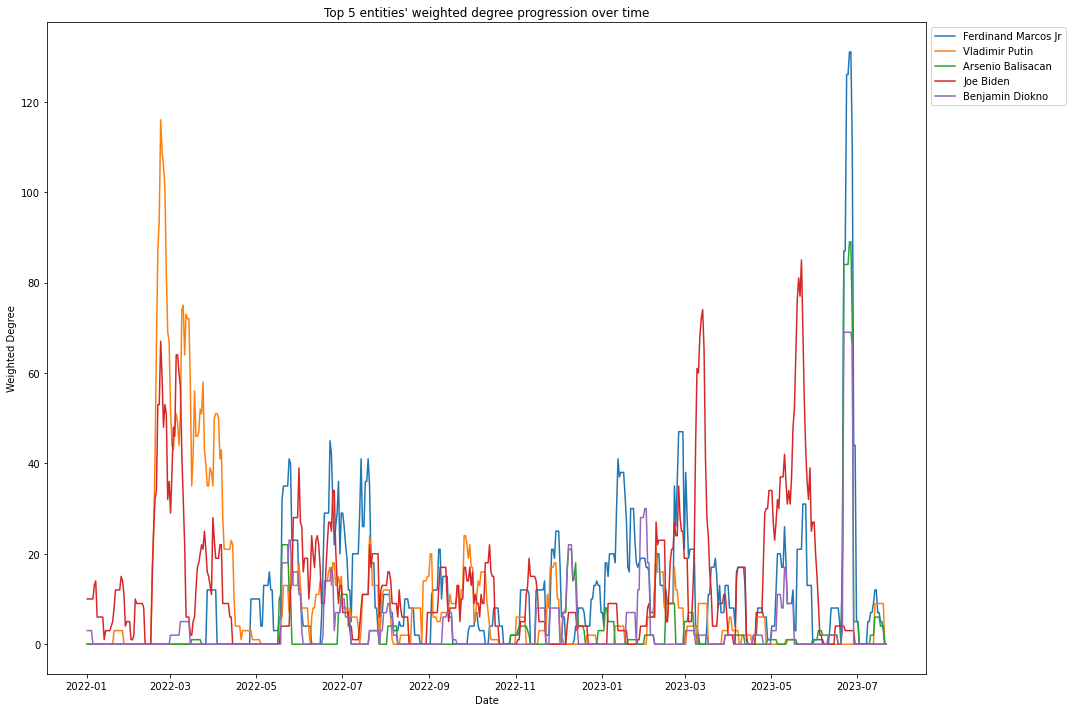

In [27]:
# Usage
weighted_rolling_window_analysis(df, 5)

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from datetime import timedelta
import imageio  # Needed to create GIFs

def weighted_rolling_window_analysis(df, p):
    df['date'] = pd.to_datetime(df['date'])
    
    start_date = df['date'].min()
    end_date = df['date'].max()
    current_date = start_date
    
    results = {}
    
    while current_date <= end_date:
        week_df = df[(df['date'] >= current_date) & (df['date'] < current_date + timedelta(7))]
        
        B = nx.Graph()
        B.add_nodes_from(week_df['id'], bipartite=0)
        entities = [entity for sublist in week_df['unique_entities'] for entity in eval(sublist)]
        B.add_nodes_from(set(entities), bipartite=1)
        for _, row in week_df.iterrows():
            for entity in eval(row['unique_entities']):
                B.add_edge(row['id'], entity)
        
        entity_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
        entity_projection = nx.bipartite.weighted_projected_graph(B, entity_nodes)
        
        weighted_degree_dict = dict(entity_projection.degree(weight='weight'))
        for entity, degree in weighted_degree_dict.items():
            if entity not in results:
                results[entity] = []
            results[entity].append((current_date, degree))
        
        current_date += timedelta(1)

    all_dates = pd.date_range(start_date, end_date)
    for entity in results:
        existing_dates = {date for date, _ in results[entity]}
        missing_dates = set(all_dates) - existing_dates
        for missing_date in missing_dates:
            results[entity].append((missing_date, 0))
        results[entity].sort()

    max_degree_entities = sorted(results, key=lambda x: max([degree for _, degree in results[x]]), reverse=True)
    top_p_entities = max_degree_entities[:p]
    
    # Fetch default matplotlib colors
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_dict = {entity: color for entity, color in zip(top_p_entities, default_colors)}

    filenames = []
    for index, focus_entity in enumerate(top_p_entities):
        plt.figure(figsize=(18, 8))

        # Lists to store line handles and labels for creating the legend
        line_handles = []
        line_labels = []

        # Plot all non-focused entities and store their handles/labels
        for entity in top_p_entities:
            values = results[entity]
            dates, degrees = zip(*values)
            if entity != focus_entity:
                line, = plt.plot(dates, degrees, '-', color='lightgray', alpha=0.6)
                line_handles.append(line)
                line_labels.append(entity)

        # Plot the focused entity and store its handle/label
        values = results[focus_entity]
        dates, degrees = zip(*values)
        focused_line, = plt.plot(dates, degrees, '-', linewidth=2.5, color=color_dict[focus_entity])
        line_handles.append(focused_line)
        line_labels.append(focus_entity)

        plt.ylabel("Weighted Degree")
        plt.xlabel("Date")
        plt.title(f"Entity Projection Weighted Degree Progression Over Time")

        # Use the line_handles and line_labels lists to ensure the legend order is maintained
        plt.legend(handles=line_handles, labels=line_labels, loc='upper left', bbox_to_anchor=(0,1), ncol=1)

        plt.tight_layout()
        filename = f"{focus_entity}_plot.png"
        plt.savefig(filename, dpi=150)
        filenames.append(filename)
        plt.close()



    # Create GIF
    with imageio.get_writer('entity_progression.gif', mode='I', duration=1) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)


In [77]:
def weighted_rolling_window_analysis(df, p):
    df['date'] = pd.to_datetime(df['date'])
    
    start_date = df['date'].min()
    end_date = df['date'].max()
    current_date = start_date
    
    results = {}
    
    while current_date <= end_date:
        week_df = df[(df['date'] >= current_date) & (df['date'] < current_date + timedelta(7))]
        
        B = nx.Graph()
        B.add_nodes_from(week_df['id'], bipartite=0)
        entities = [entity for sublist in week_df['unique_entities'] for entity in eval(sublist)]
        B.add_nodes_from(set(entities), bipartite=1)
        for _, row in week_df.iterrows():
            for entity in eval(row['unique_entities']):
                B.add_edge(row['id'], entity)
        
        entity_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
        entity_projection = nx.bipartite.weighted_projected_graph(B, entity_nodes)
        
        weighted_degree_dict = dict(entity_projection.degree(weight='weight'))
        for entity, degree in weighted_degree_dict.items():
            if entity not in results:
                results[entity] = []
            results[entity].append((current_date, degree))
        
        current_date += timedelta(1)

    all_dates = pd.date_range(start_date, end_date)
    for entity in results:
        existing_dates = {date for date, _ in results[entity]}
        missing_dates = set(all_dates) - existing_dates
        for missing_date in missing_dates:
            results[entity].append((missing_date, 0))
        results[entity].sort()

    max_degree_entities = sorted(results, key=lambda x: max([degree for _, degree in results[x]]), reverse=True)
    top_p_entities = max_degree_entities[:p]
    
    # Fetch default matplotlib colors
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_dict = {entity: color for entity, color in zip(top_p_entities, default_colors)}

    filenames = []
    for index, focus_entity in enumerate(top_p_entities):
        plt.figure(figsize=(18, 8))
        
        line_handles = []
        line_labels = []

        # Plot all entities in background, including the focused entity
        for entity in top_p_entities:
            values = results[entity]
            dates, degrees = zip(*values)
            if entity != focus_entity:
                line, = plt.plot(dates, degrees, '-', color='lightgray', alpha=0.6)
            else:
                line, = plt.plot(dates, degrees, '-', color=color_dict[entity], linewidth=2.5)
            line_handles.append(line)
            line_labels.append(entity)

        # Replot the focused entity to ensure it's in the foreground
        values = results[focus_entity]
        dates, degrees = zip(*values)
        plt.plot(dates, degrees, '-', linewidth=2.5, color=color_dict[focus_entity])

        plt.ylabel("Weighted Degree")
        plt.xlabel("Date")
        plt.legend(line_handles, line_labels, loc='upper left')
        plt.tight_layout()
        filename = f"{focus_entity}_plot.png"
        plt.savefig(filename, dpi=150)
        filenames.append(filename)
        plt.close()

    # Create GIF
    with imageio.get_writer('entity_progression.gif', mode='I', duration=1) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)


In [78]:
weighted_rolling_window_analysis(df, 5)  # Replace 'your_dataframe' with your actual DataFrame

# creating temporal plot

In [9]:
from tqdm import tqdm
import os
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors as mcolors

In [10]:
def get_window_graph(df, start_date):
    window_df = df[(df['date'] >= start_date) & (df['date'] < start_date + pd.Timedelta(days=7))]
    G = nx.Graph()
    for _, row in window_df.iterrows():
        article_id = row['id']
        entities = eval(row['unique_entities'])  # Converting the string list to a Python list
        for entity in entities:
            G.add_edge(article_id, entity)
    return G

def get_node_color(node, track_entities_colors):
    return mcolors.to_rgba(track_entities_colors.get(node, 'gray'), alpha=0.8 if node in track_entities_colors else 0.3)

def get_edge_color(edge, track_entities_colors, G):
    source, target = edge
    for node in [source, target]:
        if node in track_entities_colors:
            return mcolors.to_rgba(track_entities_colors[node], alpha=0.5)
    return (0.5, 0.5, 0.5, 0.2)

def average_positions(pos1, pos2, weight=0.75):
    """
    Average two sets of positions. Only nodes that exist in both sets are averaged.
    """
    avg_pos = {}
    for node in pos1:
        if node in pos2:
            x1, y1 = pos1[node]
            x2, y2 = pos2[node]
            avg_pos[node] = ((x1*(1-weight) + x2*weight), (y1*(1-weight) + y2*weight))
        else:
            avg_pos[node] = pos1[node]
    return avg_pos

# Assuming df is your DataFrame with columns 'date', 'id', and 'unique_entities'
# Initialize

track_entities_colors = {
    'Vladimir Putin': 'red',
    'Ferdinand Marcos Jr': 'blue',
    'Joe Biden': 'green'
}

start_date = df['date'].min()
end_date = df['date'].max() - pd.Timedelta(days=6)

frames_folder = "frames_folder"
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

current_G = get_window_graph(df, start_date)
pos = nx.spring_layout(current_G, seed=42, k=0.9, iterations=200, scale=0.95)
sub_frames_count = 25

dates = [start_date + pd.Timedelta(days=i) for i in range((end_date - start_date).days + 1)]

for i in tqdm(range(len(dates) - 1)):
    current_date = dates[i]
    next_date = dates[i + 1]

    next_G = get_window_graph(df, next_date)
    pos_next_random = nx.spring_layout(next_G, seed=42, k=0.9, iterations=200, scale=0.95)
    pos_next = average_positions(pos_next_random, pos)

    for t in np.linspace(0, 1, sub_frames_count)[:-1]:
        intermediate_pos = {}
        for node in current_G.nodes():
            if node in pos and node in pos_next:
                x1, y1 = pos[node]
                x2, y2 = pos_next[node]
                intermediate_pos[node] = (x1 + t * (x2 - x1), y1 + t * (y2 - y1))
            elif node in pos:
                intermediate_pos[node] = pos[node]
        
        plt.figure(figsize=(8, 6))
        node_colors = [get_node_color(node, track_entities_colors) for node in current_G.nodes()]
        edge_colors = [get_edge_color(edge, track_entities_colors, current_G) for edge in current_G.edges()]

        nx.draw(current_G, intermediate_pos, with_labels=False, node_color=node_colors, edge_color=edge_colors, node_size=100)
        
        for entity, color in track_entities_colors.items():
            plt.plot(0, 0, color=mcolors.to_rgba(color, alpha=0.6), label=entity)
        plt.legend(loc="upper right")
        
        month_year = current_date.strftime('%B %Y')
        plt.suptitle(f"Entity Network around {month_year}", y=1.02)

        filename = os.path.join(frames_folder, f"frame_{current_date}_t{int(100*t)}.png")
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.5, dpi=100)
        plt.close()

    current_G = next_G
    pos = pos_next

100%|███████████████████████████████████████| 560/560 [1:11:08<00:00,  7.62s/it]


In [14]:
def get_window_graph(df, start_date):
    window_df = df[(df['date'] >= start_date) & (df['date'] < start_date + pd.Timedelta(days=7))]
    G = nx.Graph()
    for _, row in window_df.iterrows():
        article_id = row['id']
        entities = eval(row['unique_entities'])  # Converting the string list to a Python list
        for entity in entities:
            G.add_edge(article_id, entity)
    return G

def get_node_color(node, track_entities_colors):
    return mcolors.to_rgba(track_entities_colors.get(node, 'gray'), alpha=0.8 if node in track_entities_colors else 0.3)

def get_edge_color(edge, track_entities_colors, G):
    source, target = edge
    for node in [source, target]:
        if node in track_entities_colors:
            return mcolors.to_rgba(track_entities_colors[node], alpha=0.5)
    return (0.5, 0.5, 0.5, 0.2)

def average_positions(pos1, pos2, weight=0.75):
    """
    Average two sets of positions. Only nodes that exist in both sets are averaged.
    """
    avg_pos = {}
    for node in pos1:
        if node in pos2:
            x1, y1 = pos1[node]
            x2, y2 = pos2[node]
            avg_pos[node] = ((x1*(1-weight) + x2*weight), (y1*(1-weight) + y2*weight))
        else:
            avg_pos[node] = pos1[node]
    return avg_pos

# Assuming df is your DataFrame with columns 'date', 'id', and 'unique_entities'
# Initialize

track_entities_colors = {
    'Vladimir Putin': 'red',
    'Ferdinand Marcos Jr': 'blue',
    'Joe Biden': 'green'
}

start_date = df['date'].min()
end_date = df['date'].max() - pd.Timedelta(days=6)

frames_folder = "frames_folder"
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

current_G = get_window_graph(df, start_date)
pos = nx.spring_layout(current_G, seed=42, k=0.9, iterations=200, scale=0.95)
sub_frames_count = 10

dates = [start_date + pd.Timedelta(days=i) for i in range((end_date - start_date).days + 1)]

# Precompute the global xlim and ylim to keep the zoom level consistent across frames
all_positions = [pos]
all_x = []
all_y = []

for i in tqdm(range(len(dates) - 1)):
    next_date = dates[i + 1]
    next_G = get_window_graph(df, next_date)
    pos_next_random = nx.spring_layout(next_G, seed=42, k=0.9, iterations=200, scale=0.95)
    pos_next = average_positions(pos_next_random, pos)
    all_positions.append(pos_next)
    all_x.extend([coord[0] for coord in pos_next.values()])
    all_y.extend([coord[1] for coord in pos_next.values()])

margin = 0.05  # 5% margin

x_range = max(all_x) - min(all_x)
y_range = max(all_y) - min(all_y)

xlim = (min(all_x) - margin * x_range, max(all_x) + margin * x_range)
ylim = (min(all_y) - margin * y_range, max(all_y) + margin * y_range)

for i in tqdm(range(len(dates) - 1)):
    current_date = dates[i]
    next_date = dates[i + 1]

    next_G = get_window_graph(df, next_date)
    pos_next_random = nx.spring_layout(next_G, seed=42, k=0.9, iterations=200, scale=0.95)
    pos_next = average_positions(pos_next_random, pos)

    for t in np.linspace(0, 1, sub_frames_count)[:-1]:
        intermediate_pos = {}
        for node in current_G.nodes():
            if node in pos and node in pos_next:
                x1, y1 = pos[node]
                x2, y2 = pos_next[node]
                intermediate_pos[node] = (x1 + t * (x2 - x1), y1 + t * (y2 - y1))
            elif node in pos:
                intermediate_pos[node] = pos[node]
        
        plt.figure(figsize=(8, 6))
        node_colors = [get_node_color(node, track_entities_colors) for node in current_G.nodes()]
        edge_colors = [get_edge_color(edge, track_entities_colors, current_G) for edge in current_G.edges()]

        nx.draw(current_G, intermediate_pos, with_labels=False, node_color=node_colors, edge_color=edge_colors, node_size=100)
        plt.xlim(xlim)  # Fixing the x-axis limits
        plt.ylim(ylim)  # Fixing the y-axis limits

        for entity, color in track_entities_colors.items():
            plt.plot(0, 0, color=mcolors.to_rgba(color, alpha=0.6), label=entity)
        plt.legend(loc="upper right")
        
        month_year = current_date.strftime('%B %Y')
        plt.suptitle(f"Entity Network around {month_year}", y=1.02)

        filename = os.path.join(frames_folder, f"frame_{current_date}_t{int(100*t)}.png")
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.5, dpi=80)
        plt.close()

    current_G = next_G
    pos = pos_next

100%|█████████████████████████████████████████| 560/560 [16:22<00:00,  1.75s/it]


In [9]:
start_date = df['date'].min()
end_date = df['date'].max() - pd.Timedelta(days=6)
dates = [start_date + pd.Timedelta(days=i) for i in range((end_date - start_date).days + 1)]
sub_frames_count = 15
frames_folder = "frames_folder"

In [10]:
fps = 30
frames = [imageio.imread(os.path.join(frames_folder, f"frame_{dates[i]}_t{int(100*t)}.png")) 
          for i in range(len(dates) - 1) for t in np.linspace(0, 1, sub_frames_count)[:-1]]
imageio.mimsave("animated_entity_network6.gif", frames, duration=1/fps)

In [16]:
fps = 120
frames = [imageio.imread(os.path.join(frames_folder, f"frame_{dates[i]}_t{int(100*t)}.png")) 
          for i in range(len(dates) - 1) for t in np.linspace(0, 1, sub_frames_count)[:-1]]
imageio.mimsave("animated_entity_network8.gif", frames, duration=1/fps)

In [44]:
from pygifsicle import optimize

optimize("animated_entity_network8.gif", "animated_entity_network9.gif")

gifsicle: warning: huge GIF, conserving memory (processing may take a while)
gifsicle: warning: trivial adaptive palette (only 256 colors in source)


In [2]:
from moviepy.editor import VideoFileClip

clip = VideoFileClip('animated_entity_network8.gif')
clip.write_gif('animated_entity_network10.gif', fps=5)  # Using reduced FPS too

MoviePy - Building file animated_entity_network10.gif with imageio.


In [36]:
dates = [start_date + pd.Timedelta(days=i) for i in range((end_date - start_date).days + 1)]
windows = [(date, get_window_graph(df, date)) for date in dates]

# Finding window with smallest and largest number of nodes
window_min_nodes = min(windows, key=lambda x: len(x[1].nodes()))
window_max_nodes = max(windows, key=lambda x: len(x[1].nodes()))

# Finding window with smallest and largest number of edges (links)
window_min_edges = min(windows, key=lambda x: len(x[1].edges()))
window_max_edges = max(windows, key=lambda x: len(x[1].edges()))


Analysis for Window starting at 2022-05-05 12:59:53:


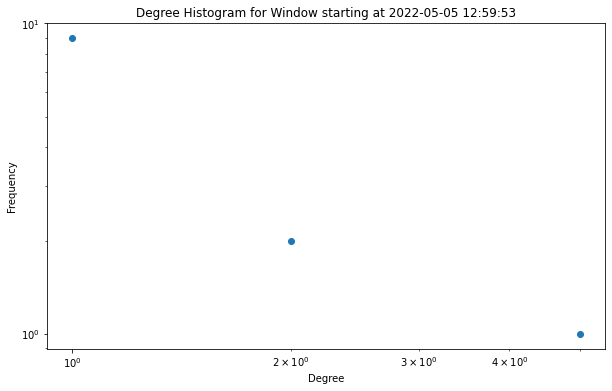

Average Clustering Coefficient: 0.0
The graph for Window starting at 2022-05-05 12:59:53 is not connected. Cannot compute average shortest path length.
Density: 0.13636363636363635
Average Degree Centrality: 0.13636363636363635
Average Closeness Centrality: 0.21380471380471378
Average Betweenness Centrality: 0.018181818181818184
Average Eigenvector Centrality: 0.19068944862260565
--------------------------------------------------
Analysis for Window starting at 2022-03-05 12:59:53:


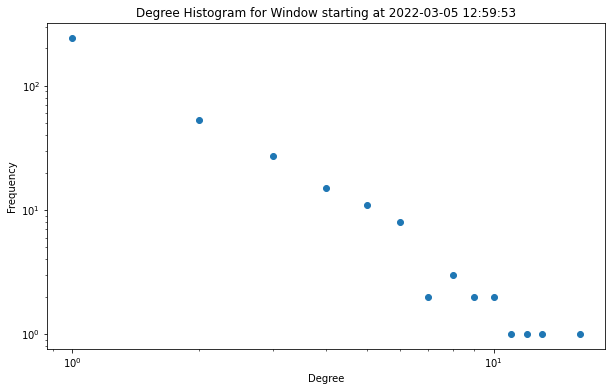

Average Clustering Coefficient: 0.0
The graph for Window starting at 2022-03-05 12:59:53 is not connected. Cannot compute average shortest path length.
Density: 0.0052597071464995995
Average Degree Centrality: 0.005259707146499579
Average Closeness Centrality: 0.04695988220413399
Average Betweenness Centrality: 0.0035152765019308943
Average Eigenvector Centrality: 0.020667030947511485
--------------------------------------------------
Analysis for Window starting at 2022-05-05 12:59:53:


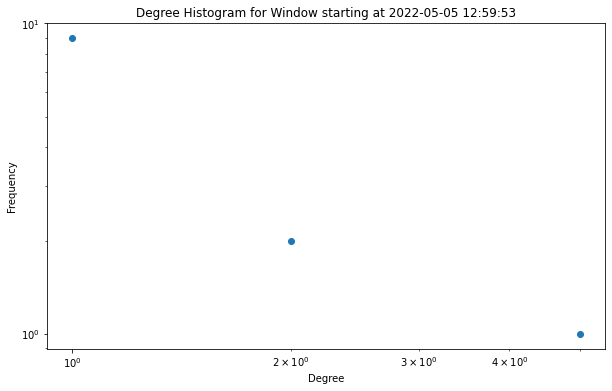

Average Clustering Coefficient: 0.0
The graph for Window starting at 2022-05-05 12:59:53 is not connected. Cannot compute average shortest path length.
Density: 0.13636363636363635
Average Degree Centrality: 0.13636363636363635
Average Closeness Centrality: 0.21380471380471378
Average Betweenness Centrality: 0.018181818181818184
Average Eigenvector Centrality: 0.19068944862260565
--------------------------------------------------
Analysis for Window starting at 2022-03-05 12:59:53:


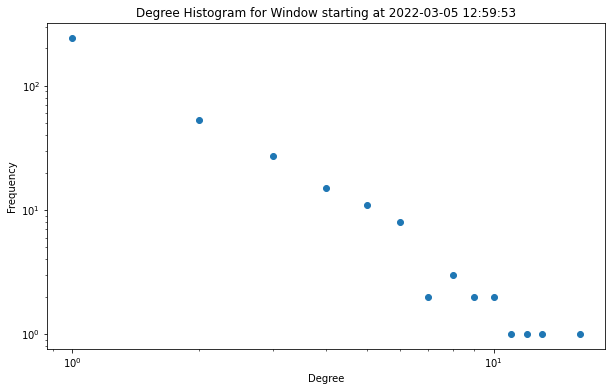

Average Clustering Coefficient: 0.0
The graph for Window starting at 2022-03-05 12:59:53 is not connected. Cannot compute average shortest path length.
Density: 0.0052597071464995995
Average Degree Centrality: 0.005259707146499579
Average Closeness Centrality: 0.04695988220413399
Average Betweenness Centrality: 0.0035152765019308943
Average Eigenvector Centrality: 0.020667030947511485
--------------------------------------------------


In [38]:
def perform_network_analysis(graph, graph_title):
    print(f"Analysis for {graph_title}:")

    # 1. Degree Distribution
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    deg, cnt = zip(*degree_count.items())

    plt.figure(figsize=(10, 6))
    plt.loglog(deg, cnt, 'o')
    plt.title("Degree Histogram for " + graph_title)
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # 2. Clustering Coefficient
    avg_clustering = nx.average_clustering(graph)
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # 3. Average Shortest Path Length (this can be computationally intensive for large networks)
    # First, check if the graph is connected
    if nx.is_connected(graph):
        avg_path_length = nx.average_shortest_path_length(graph)
        print(f"Average Shortest Path Length: {avg_path_length}")
    else:
        print(f"The graph for {graph_title} is not connected. Cannot compute average shortest path length.")

    # 4. Density
    density = nx.density(graph)
    print(f"Density: {density}")

    # 5. Degree Centrality
    degree_centrality = nx.degree_centrality(graph)
    avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
    print(f"Average Degree Centrality: {avg_degree_centrality}")

    # 6.Closeness Centrality
    closeness_centrality = nx.closeness_centrality(graph)
    avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
    print(f"Average Closeness Centrality: {avg_closeness_centrality}")

    # 7. Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(graph)
    avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
    print(f"Average Betweenness Centrality: {avg_betweenness_centrality}")

    # 8. Eigenvector Centrality
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
    avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
    print(f"Average Eigenvector Centrality: {avg_eigenvector_centrality}")
    print("-" * 50)


# Call this function for each of the windows
windows_to_analyze = [window_min_nodes, window_max_nodes, window_min_edges, window_max_edges]
for window in windows_to_analyze:
    window_date, window_graph = window
    window_title = f"Window starting at {window_date}"
    perform_network_analysis(window_graph, window_title)
